In [24]:
# Import necessary modules
#import geopandas as gpd
#import geocube    
#from mpl_toolkits.basemap import Basemap
#from matplotlib import pyplot as plt
import rasterio

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature  
from matplotlib import pyplot
#import rasterstats
import regionmask
import xarray as xr
import xesmf as xe

import geopandas as gpd

#import rasterstats as rs

import numpy as np

In [2]:
regionmask.__version__

'0.4.0'

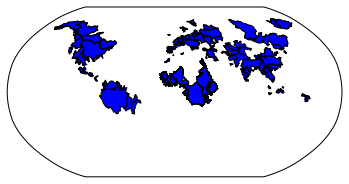

In [10]:
ax = plt.axes(projection=ccrs.Robinson())
shape_feature = ShapelyFeature(Reader('Major_Basins_of_the_World.dbf').geometries(),
                                ccrs.PlateCarree(), edgecolor='black')
ax.add_feature(shape_feature, facecolor='blue')
plt.show()

In [13]:
PATH_TO_SHAPEFILE = 'Major_Basins_of_the_World.dbf'
# Read file using gpd.read_file()
basins = gpd.read_file(PATH_TO_SHAPEFILE)
basins = basins[basins.geometry!=None]

In [14]:
# load in era5 data
era5 = xr.open_dataset('era_runoff_mean.nc')
# fix the data to align with shapefile formatting
era5 = era5.rename({'lon': 'longitude',
                   'lat': 'latitude'})
era5 = era5.assign_coords(longitude=(((era5.longitude + 180) % 360) 
                                     - 180)).sortby('longitude')

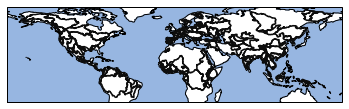

In [15]:
basins_mask_poly = regionmask.Regions_cls(name='basins_mask', 
                                    numbers=list(range(0,204)), 
                                    names=list(basins.NAME), 
                                    abbrevs=list(basins.NAME), 
                                    outlines=list(basins.geometry.values[i] 
                                                  for i in range(0,204)))
basins_mask_poly.plot(add_label=False)

In [16]:
mask = basins_mask_poly.mask(era5, lat_name='latitude', 
                            lon_name='longitude',
                            wrap_lon=False)

In [ ]:
# Now mask out a single river basin

In [17]:
basins['ro'] = np.nan
lat = mask.latitude.values
lon = mask.longitude.values

for ID_REGION in range(0,204):
    try:
        sel_mask = mask.where(mask == ID_REGION).values
        id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
        id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]
        out_sel = era5.sel(latitude = slice(id_lat[0], id_lat[-1]), 
                        longitude = slice(id_lon[0], id_lon[-1])
                       ).compute().where(mask == ID_REGION)
        basins.at[ID_REGION, 'ro'] = float(out_sel.mean(dim = ['latitude', 'longitude']).ro.values)
    except:
        # some of the basins are too tiny to contain any gridcells
        continue

In [ ]:
plt.figure(figsize=(10,6))
basins_mask_poly.plot(add_label=False)
mask.plot()

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


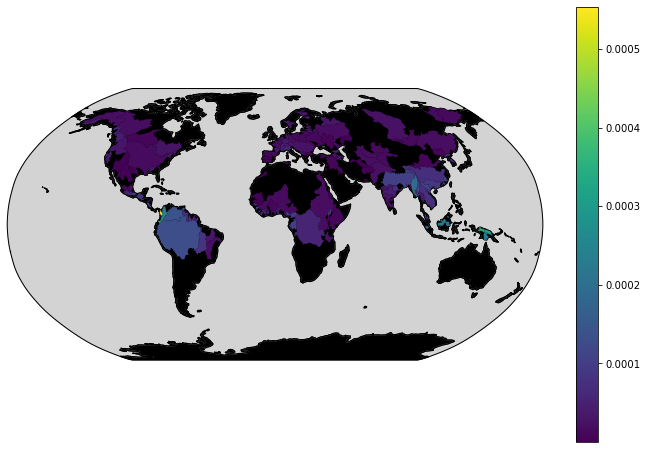

In [29]:
fig, axarr = plt.subplots(1,1, figsize=(12,8), 
                          subplot_kw=dict(projection=ccrs.Robinson()))


# out_sel.ro.plot(ax = ax)
p = basins.plot(ax = axarr, column='ro', vmax=, 
            zorder=40, transform=ccrs.PlateCarree(), legend=True)#, facecolor = 'ro')
plot_nicely(axarr)

In [28]:
def plot_nicely(ax, title=None):
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, color='black')
    ax.add_feature(cartopy.feature.OCEAN, color='lightgrey')
    ax.set_title(title)

    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-')


In [135]:

basin_of_interest = 'Yenisey'
get_mask = basins[basins['NAME'] in ["Yenisey", 'Columbia']]#.index.values[0]

basins_mask_poly = regionmask.Regions_cls(name='basins_mask', 
                                      numbers=list(get_mask.index.values[0]), 
                                      names=list(get_mask.NAME), 
                                      abbrevs=list(get_mask.NAME), 
                                      outlines=list(get_mask.geometry.values[i] for i in range(0,254)))
basins_mask_poly.plot()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().